1. input svg
2. deconstruct svg into layers
3. prepare each layer (masking), some layers have interaction
4. parse through terrain algorithm to get heightmap

In [9]:
import sys

sys.path.append('../terrain-erosion-3-ways/')
from river_network import *

sys.path.append("../pipeline")
from svg_extraction import SVGExtractor
from svg_extraction import get_city_coordinates, get_island_coordinates
from image_ops import flood_image

import numpy as np

from omegaconf import OmegaConf

import matplotlib.pyplot as plt
import png
import PIL

In [10]:
realm_number = 4

In [11]:
config = OmegaConf.load("../pipeline/config.yaml")
# this is how you can access the config
# we will use padding more often
p = config.svg.padding
config

{'svg': {'scaling': 2.0, 'padding': 50}, 'closing': {'min_n_points': 3, 'rng': 448, 'magnet': 10}, 'pipeline': {'use_rivers': True, 'use_cities': True, 'use_islands': True}, 'terrain': {'land': {'disc_radius': 1.0, 'max_delta': 0.05, 'river_downcutting_constant': 1.3, 'directional_inertia': 5.0, 'default_water_level': 1.0, 'evaporation_rate': 0.2, 'coastal_dropoff': 80.0, 'mountain_sigma': 50.0, 'lakes_alpha': 0.8, 'mountain_lower': 2.0, 'mountain_shape_offset': 50.0, 'mountain_offset': 0.1}, 'water_padding': 20, 'water': {'disc_radius': 1.0, 'max_delta': 0.05, 'river_downcutting_constant': 1.3, 'directional_inertia': 0.4, 'default_water_level': 1.0, 'evaporation_rate': 0.2, 'coastal_dropoff': 80.0, 'mountain_sigma': 5.0, 'lakes_alpha': 0.8, 'mountain_lower': 2.0, 'mountain_shape_offset': 0.4, 'mountain_offset': 0.1}}, 'export': {'size': 700, 'out_dir': 'MagicaVoxel-0.99.6.4-win64/vox'}}

In [12]:
extractor = SVGExtractor(f"../svgs/{realm_number}.svg", scale=config.svg.scaling)

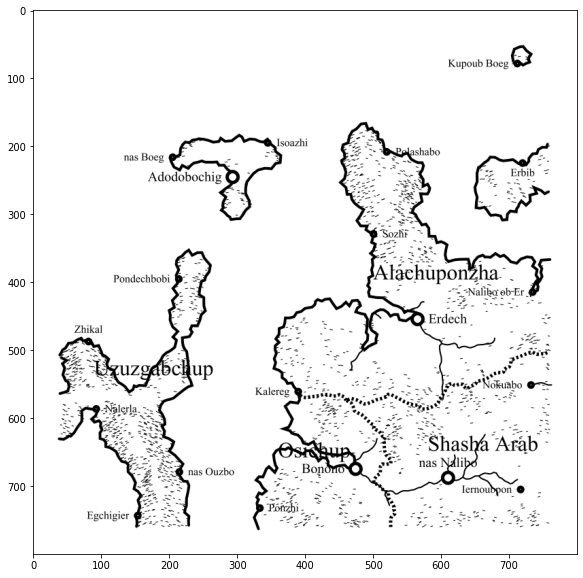

In [13]:
extractor.show()

In [14]:
drawing = extractor.coast()

In [15]:
def close_svg(drawing, rng=448, magnet=10):
    """This function tries to find open ends of paths and
    connects the ends while going around the image borders.
    
    Paths of lenght < 4 will be ignored.
    
    Args:
        - drawing: the drawing containing paths from extractor.coast()
        - rng: distance of the edge wrt center
        - magnet: range of finding other endpoints wrt rng
    
    Returns:
        (1) list of lines that can be used to close the paths
        (2) drawing with closed paths
    """
    paths = drawing.contents[0].contents[0].contents

    arrays = []
    for shape_group in drawing.contents[0].contents:
        path = shape_group.contents[0]
        plen = len(path.points)
        split_array = [[path.points[x],path.points[x+1]] for x in range(0,plen,2)]
        np_array = np.array(split_array)
        if len(np_array>3):
            arrays.append(np_array)
    al = np.vstack(arrays)
    
    # find the beginning-end points
    begends = []
    begends_list = []
    for a in arrays:
        begends.append({
            "beg": a[0],
            "end": a[-1],
        })
        begends_list.append(a[0])
        begends_list.append(a[-1])
        
    # filter out begend points that are too far from rng
    begends_list = [
        a for a in begends_list
        if rng-magnet < abs(a[0]) < rng+magnet or rng-magnet < abs(a[1]) < rng+magnet
    ]
    
    lefts = [
    a for a in begends_list
        if -rng-magnet < a[0] < -rng+magnet
    ]
    lefts.sort(key=lambda x: -x[1])
    
    bottoms = [
        a for a in begends_list
        if -rng-magnet < a[1] < -rng+magnet
    ]
    bottoms.sort(key=lambda x: x[0])
    
    rights = [
        a for a in begends_list
        if rng-magnet < a[0] < rng+magnet
    ]
    rights.sort(key=lambda x: x[1])
    
    tops = [
        a for a in begends_list
        if rng-magnet < a[1] < rng+magnet
    ]
    tops.sort(key=lambda x: -x[0])
    
    # imagine a pen starting at the upper left corner and going up or
    # down when it encounters an end point.
    lines = []

    up_left = np.array([-rng, rng])
    bottom_left = np.array([-rng, -rng])
    bottom_right = np.array([rng, -rng])
    up_right = np.array([rng, rng])
    draw = True # this might need to change on some images

    now = up_left
    # go down from the left side
    for co in lefts:
        if draw:
            lines.append([now, co])
            draw = False
        elif not draw:
            now = co
            draw = True

    if draw:
        lines.append([now, bottom_left])
        now = bottom_left
    # go right at the bottom
    for co in bottoms:
        if draw:
            lines.append([now, co])
            draw = False
        elif not draw:
            now = co
            draw = True

    if draw:
        lines.append([now, bottom_right])
        now = bottom_right
    # go up at the right
    for co in rights:
        if draw:
            lines.append([now, co])
            draw = False
        elif not draw:
            now = co
            draw = True

    if draw:
        lines.append([now, up_right])
        now = up_right
    # go left at the top
    for co in tops:
        if draw:
            lines.append([now, co])
            draw = False
        elif not draw:
            now = co
            draw = True

    if draw:
        lines.append([now, up_left])
        
    plt.figure(figsize=(20,20))
    plt.scatter(al[:,0], -al[:,1], s=1)
    for line in lines:
        plt.plot(np.vstack(line)[:,0], -np.vstack(line)[:,1])
    plt.xlim(-500,500)
    plt.ylim(-500,500)

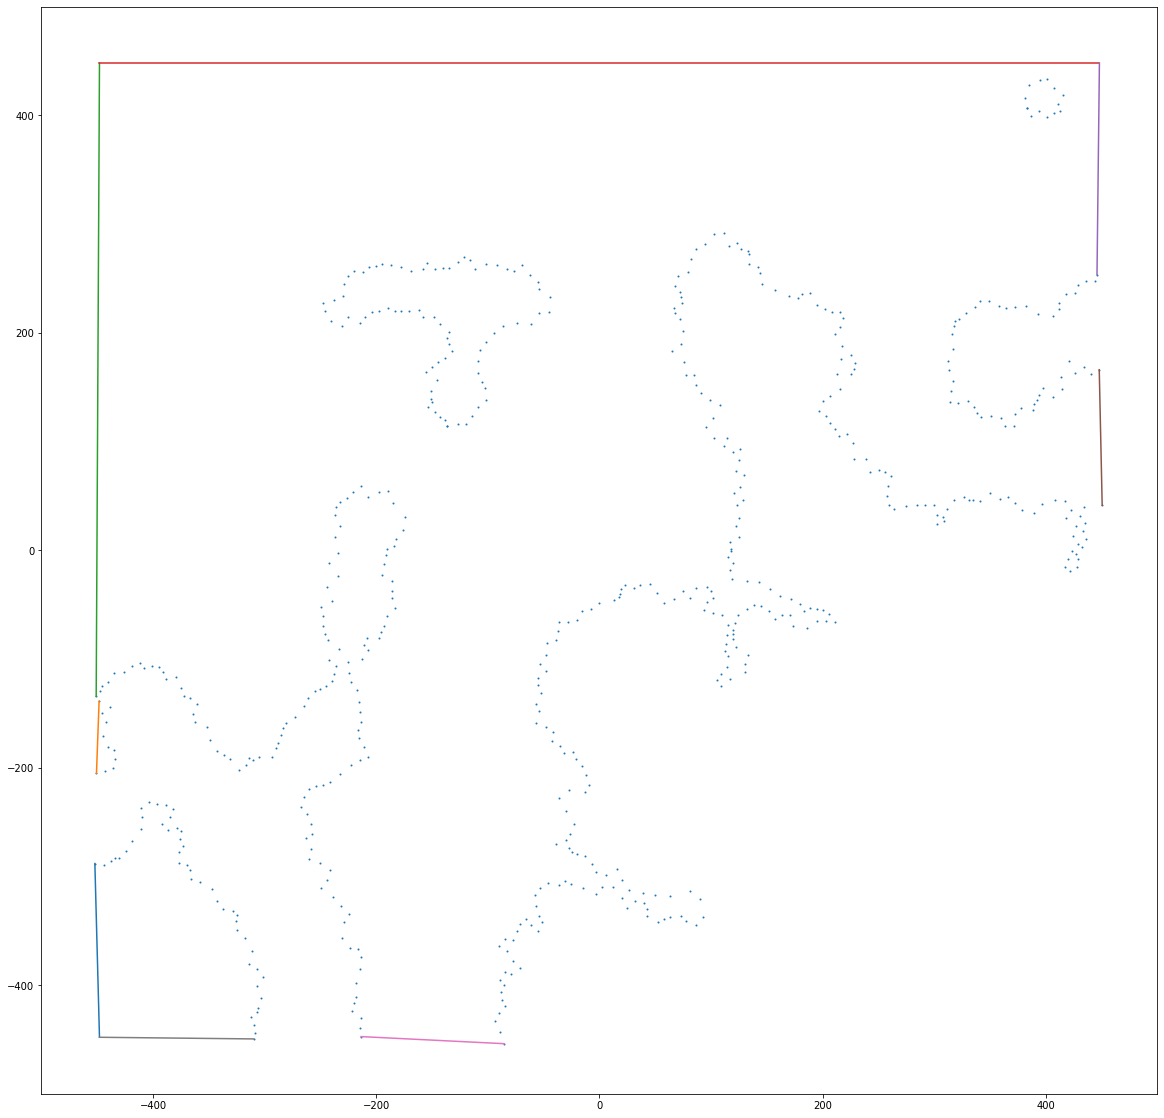

In [16]:
close_svg(drawing)

In [85]:
def close_svg(drawing, rng=460, magnet=2):
    """This function tries to find open ends of paths and
    connects the ends while going around the image borders.
    
    Paths of lenght < 4 will be ignored.
    
    Args:
        - drawing: the drawing containing paths from extractor.coast()
        - rng: distance of the edge wrt center
        - magnet: range of finding other endpoints wrt rng
    
    Returns:
        (1) list of lines that can be used to close the paths
        (2) drawing with closed paths
    """
    
    def extend(x, y, bound, limit):
        assert y != 0
        assert x != 0
        if x < -limit:
            return [-bound, y/x*-bound]
        elif x > limit:
            return [bound, y/x*bound] 
        elif y < -limit:
            return [x/y*-bound, -bound]
        elif y > limit:
            return [x/y*bound, bound]
        else:
            raise ValueError("edge not within limits.")
    
    paths = drawing.contents[0].contents[0].contents

    arrays = []
    for shape_group in drawing.contents[0].contents:
        path = shape_group.contents[0]
        plen = len(path.points)
        split_array = [[path.points[x],path.points[x+1]] for x in range(0,plen,2)]
        
        BOUND = rng
        LIMIT = 400
        # here we are injecting extra points
        if split_array[0]==split_array[-1]:
            # 'tis an island
            pass
        else:
            first, last = split_array[0], split_array[-1]
            # check coordinates on the far left:
            first = extend(first[0], first[1], BOUND, LIMIT)
            last = extend(last[0], last[1], BOUND, LIMIT)
            print(f"Extended first {first} and last {last}")
            new_array = [first]
            new_array.extend(split_array)
            new_array.append(last)
            split_array = new_array
        
        np_array = np.array(split_array)
        if len(np_array>3):
            arrays.append(np_array)
    al = np.vstack(arrays)
    
    # find the beginning-end points
    begends = []
    begends_list = []
    for a in arrays:
        begends.append({
            "beg": a[0],
            "end": a[-1],
        })
        begends_list.append(a[0])
        begends_list.append(a[-1])
        
    # filter out begend points that are too far from rng
    begends_list = [
        a for a in begends_list
        if rng-magnet < abs(a[0]) < rng+magnet or rng-magnet < abs(a[1]) < rng+magnet
    ]
    
    lefts = [
    a for a in begends_list
        if -rng-magnet < a[0] < -rng+magnet
    ]
    lefts.sort(key=lambda x: -x[1])
    
    bottoms = [
        a for a in begends_list
        if -rng-magnet < a[1] < -rng+magnet
    ]
    bottoms.sort(key=lambda x: x[0])
    
    rights = [
        a for a in begends_list
        if rng-magnet < a[0] < rng+magnet
    ]
    rights.sort(key=lambda x: x[1])
    
    tops = [
        a for a in begends_list
        if rng-magnet < a[1] < rng+magnet
    ]
    tops.sort(key=lambda x: -x[0])
    
    # imagine a pen starting at the upper left corner and going up or
    # down when it encounters an end point.
    lines = []

    up_left = np.array([-rng, rng])
    bottom_left = np.array([-rng, -rng])
    bottom_right = np.array([rng, -rng])
    up_right = np.array([rng, rng])
    draw = False # this might need to change on some images

    now = up_left
    # go down from the left side
    for co in lefts:
        if draw:
            lines.append([now, co])
            draw = False
        elif not draw:
            now = co
            draw = True

    if draw:
        lines.append([now, bottom_left])
        now = bottom_left
    # go right at the bottom
    for co in bottoms:
        if draw:
            lines.append([now, co])
            draw = False
        elif not draw:
            now = co
            draw = True

    if draw:
        lines.append([now, bottom_right])
        now = bottom_right
    # go up at the right
    for co in rights:
        if draw:
            lines.append([now, co])
            draw = False
        elif not draw:
            now = co
            draw = True

    if draw:
        lines.append([now, up_right])
        now = up_right
    # go left at the top
    for co in tops:
        if draw:
            lines.append([now, co])
            draw = False
        elif not draw:
            now = co
            draw = True

    if draw:
        lines.append([now, up_left])
        
    plt.figure(figsize=(20,20))
    plt.scatter(al[:,0], -al[:,1], s=4)
    for line in lines:
        plt.plot(np.vstack(line)[:,0], -np.vstack(line)[:,1])
    plt.xlim(-BOUND-100,BOUND+100)
    plt.ylim(-BOUND-100,BOUND+100)

Extended first [460, -42.18328571713984] and last [-86.59938312403614, 460]
Extended first [460, -261.5986703541461] and last [460, -170.50618185390857]
Extended first [-219.63624008958766, 460] and last [-460, 137.1020354761382]
Extended first [-460, 209.3302980077348] and last [-460, 142.64968874554754]
Extended first [-317.01664193696934, 460] and last [-460, 293.25872418353856]


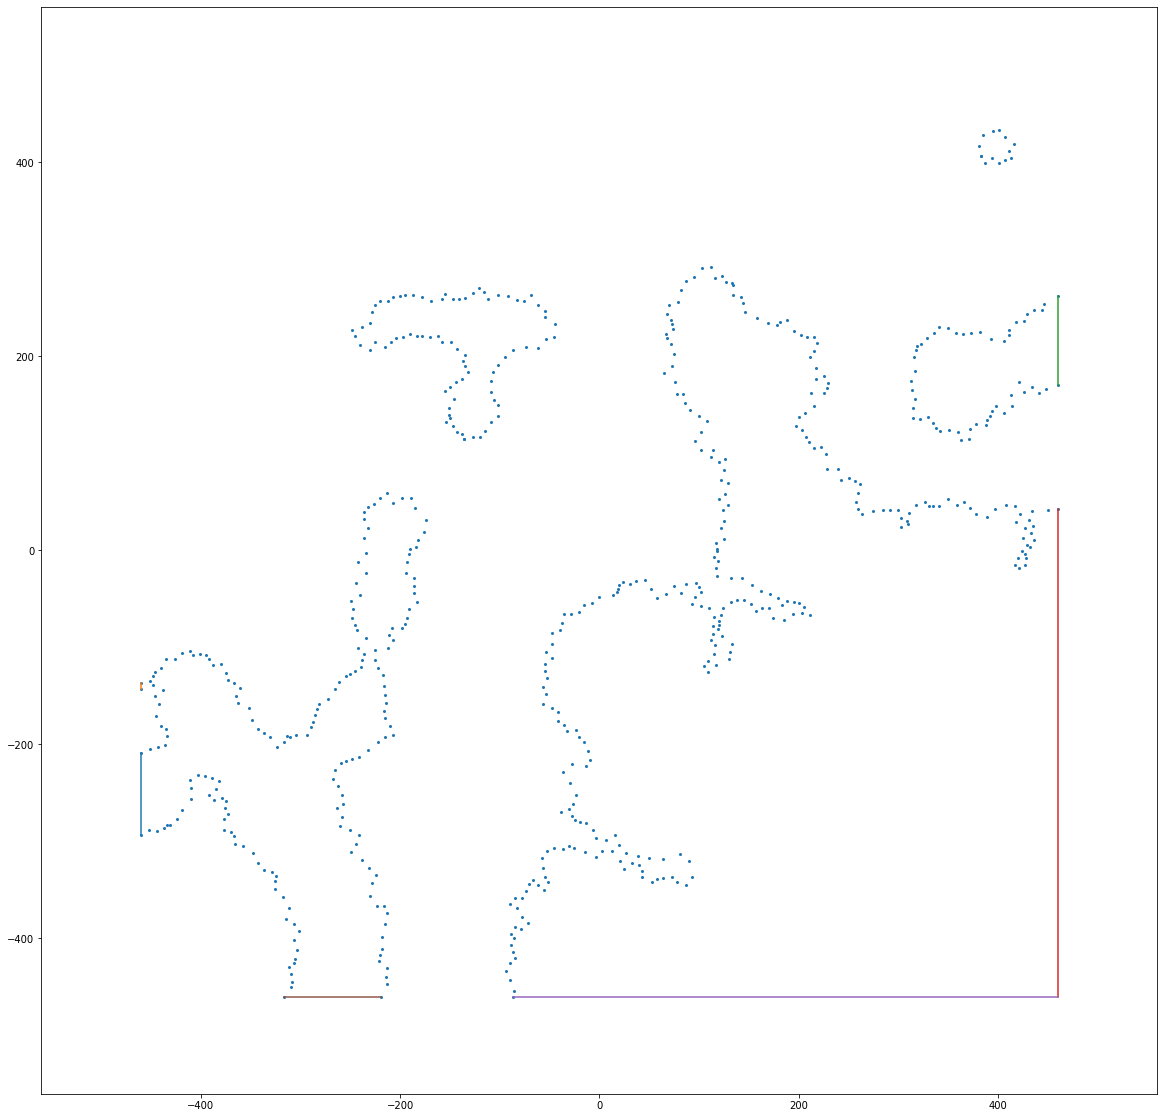

In [86]:
close_svg(drawing)